Make this notebook work by running
```
conda install -c conda-forge pyopencl
pip install beetlesafari
```

Initialize GPU

In [1]:
# Initialize GPU
import pyclesperanto_prototype as cle
import beetlesafari as bs
import numpy as np

cle.select_device('RTX')

C:\Users\rober\miniconda3\envs\bio3\lib\site-packages\magicgui\widgets\_bases\ranged_widget.py:28: FutureWarning: The 'maximum' keyword arguments has been changed to 'max'. In the future this will raise an exception

  warn(
C:\Users\rober\miniconda3\envs\bio3\lib\site-packages\magicgui\widgets\_bases\ranged_widget.py:28: FutureWarning: The 'minimum' keyword arguments has been changed to 'min'. In the future this will raise an exception

  warn(


<GeForce RTX 2080 Ti on Platform: NVIDIA CUDA (1 refs)>

Initialize napari

In [2]:
import napari
viewer = napari.Viewer()

Define data source: The "Lund" dataset (courtesy of Daniela Vorkel, Myers lab, MPI CBG)

In [3]:
path = 'C:/structure/data/2019-12-17-16-54-37-81-Lund_Tribolium_nGFP_TMR'

timepoint_in_h = 19

cc_dataset = bs.ClearControlDataset(path)

print("Duration in seconds:", cc_dataset.get_duration_in_seconds())

print("Duration in hours:", bs.seconds_to_hours(cc_dataset.get_duration_in_seconds()))

Duration in seconds: 607654.0077
Duration in hours: 168.79277991666666


Convenience methods

In [4]:
def show(image, labels=False, title=None, use_napari=False):
    """
    Visualize a given stack using matplotlib and optionally also in napari
    """
    if len(image.shape) == 3:
        # print(image.shape)
        max_projection = cle.create([image.shape[1], image.shape[2]])
        cle.maximum_z_projection(image, max_projection)
        cle.imshow(cle.transpose_xy(max_projection), labels=labels, min_display_intensity=0)
    else:
        cle.imshow(cle.transpose_xy(image), labels=labels, min_display_intensity=0)    
    
    if use_napari:
        if labels:
            viewer.add_labels(cle.pull_zyx(image).astype(int), name=title)
        else:
            viewer.add_image(cle.pull_zyx(image), name=title)


In [5]:
def make_prediction(cells, prediction):
    """
    Takes a label image of cells and a prediction vector to make a prediction label image
    """
    predicition_vector = cle.push_zyx(np.asarray([prediction]) + 1)

    # set background to 0
    cle.set_column(predicition_vector, 0, 0)
    return cle.replace_intensities(cells, predicition_vector)

def show_prediction(cells, prediction, name = "", use_napari=True):
    """
    Show prediction of all cells, per default also in napari
    """
    prediction_map = make_prediction(cells, prediction) 
    show(prediction_map, title="prediction " + name, use_napari=use_napari)

## Load image stack

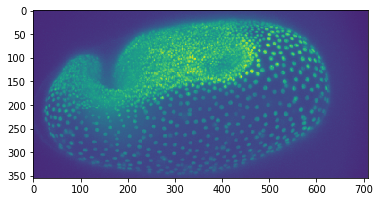

(213, 710, 355)


In [6]:
input_image = cc_dataset.get_resampled_image(time_in_seconds=bs.hours_to_seconds(timepoint_in_h), linear_interpolation=False)
show(input_image, title="original", use_napari=True)
print(input_image.shape)

# Segmentation

Segmentation took 0.9856808185577393 s


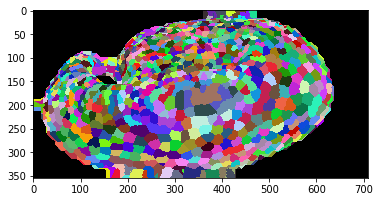

In [7]:
cells, spots = bs.segmentation(input_image, spot_detection_threshold=50)
show(cells, labels=True,  use_napari=True)

# Quantiative analysis
## Average distance of n=6 nearest neighbors

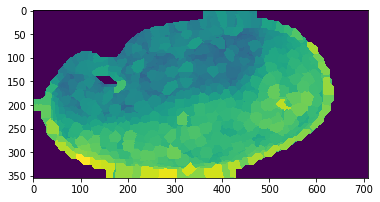

In [8]:
avg_distance_map = cle.average_distance_of_n_closest_neighbors_map(cells, n = 6)
show(avg_distance_map, labels=False, use_napari=True, title="avg_distance_map")

Standard deviation locally

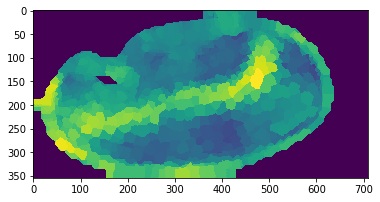

In [9]:
stddev_distance_map = cle.standard_deviation_of_touching_neighbors_map(avg_distance_map, cells, radius=2)
show(stddev_distance_map, labels=False, use_napari=True, title="stddev_distance_map")

## Locally averaged "average distance" over the touching neighbors

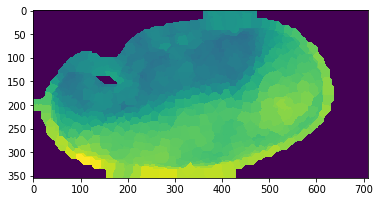

In [10]:
local_avg_distance_map = cle.mean_of_touching_neighbors_map(avg_distance_map, cells)

show(local_avg_distance_map, labels=False, use_napari=True, title="mean_distance_map")

Standard deviation locally

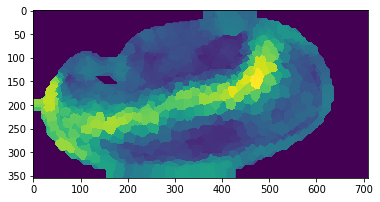

In [11]:
local_stddev_distance_map = cle.standard_deviation_of_touching_neighbors_map(local_avg_distance_map, cells, radius=2)
show(local_stddev_distance_map, labels=False, use_napari=True, title="local_stddev_distance_map")

# Collecting data

In [12]:
data =  np.asarray([
    cle.pull(cle.read_intensities_from_map(cells, avg_distance_map))[0],
    cle.pull(cle.read_intensities_from_map(cells, stddev_distance_map))[0]
]).T

local_data =  np.asarray([
    cle.pull(cle.read_intensities_from_map(cells, local_avg_distance_map))[0],
    cle.pull(cle.read_intensities_from_map(cells, local_stddev_distance_map))[0]
]).T

print(data.shape)

(1533, 2)


## Ploting the raw measurements

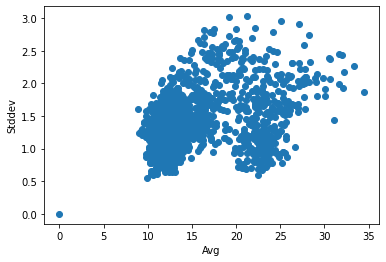

In [13]:
import matplotlib.pyplot as plt

plt.scatter(data[:,0], data[:,1])
plt.xlabel("Avg")
plt.ylabel("Stddev")
plt.show()

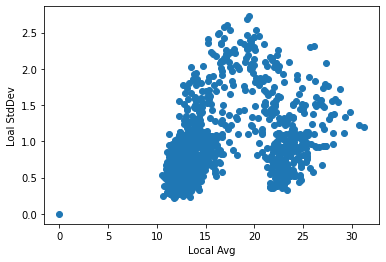

In [14]:
plt.scatter(local_data[:,0], local_data[:,1])
plt.xlabel("Local Avg")
plt.ylabel("Loal StdDev")
plt.show()

# Scaling

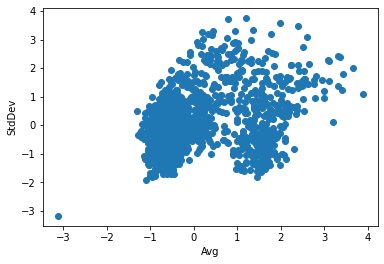

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data)
norm_data = scaler.transform(data)

plt.scatter(norm_data[:,0], norm_data[:,1])
plt.xlabel("Avg")
plt.ylabel("StdDev")
plt.show()

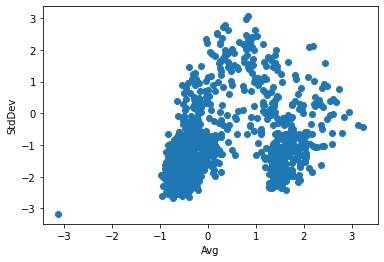

In [16]:
local_scaler = StandardScaler()
local_scaler.fit(local_data)
norm_local_data = scaler.transform(local_data)

plt.scatter(norm_local_data[:,0], norm_local_data[:,1])
plt.xlabel("Avg")
plt.ylabel("StdDev")
plt.show()

# Clustering

In [17]:
num_classes = 3

color_iter = ['navy', 'red', 'darkgreen', 'gold', 'darkorange']

print(data.shape)

(1533, 2)


## Gaussian mixture model
Train a GMM for the original data first

In [18]:
from sklearn import mixture

# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=num_classes, covariance_type='full')
gmm.fit(norm_data)

# prediction
gmm_prediction = gmm.predict(norm_data)

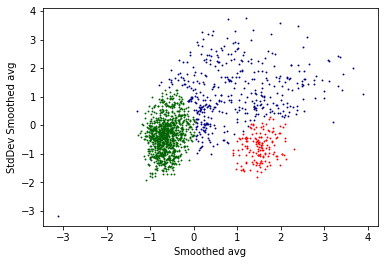

In [19]:
for i in range(num_classes):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(norm_data[gmm_prediction == i, 0], norm_data[gmm_prediction == i, 1], .8, color=color)

plt.xlabel("Smoothed avg")
plt.ylabel("StdDev Smoothed avg")
plt.show()

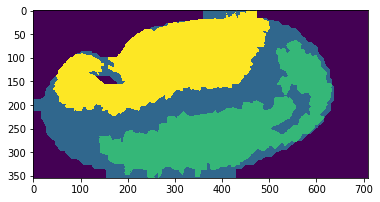

In [20]:
show_prediction(cells, gmm_prediction, "Gaussian Mixture")

Now train another GMM using the locally smoothed data 

In [21]:
# fit a Gaussian Mixture Model with two components
local_gmm = mixture.GaussianMixture(n_components=num_classes, covariance_type='full')
local_gmm.fit(norm_local_data)

# prediction
local_gmm_prediction = local_gmm.predict(norm_local_data)

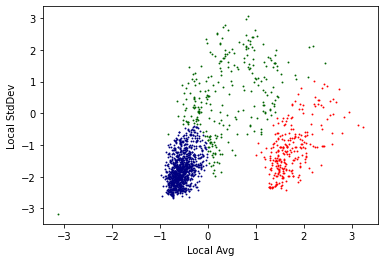

In [22]:
for i in range(num_classes):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(norm_local_data[local_gmm_prediction == i, 0], norm_local_data[local_gmm_prediction == i, 1], .8, color=color)

plt.xlabel("Local Avg")
plt.ylabel("Local StdDev")
plt.show()

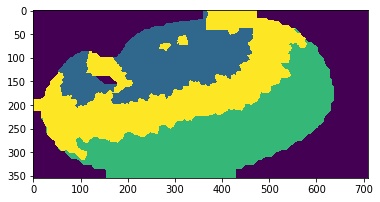

In [23]:
show_prediction(cells, local_gmm_prediction, "Gaussian Mixture")

## K-means clustering
Again, we train KMC on the raw measurements first

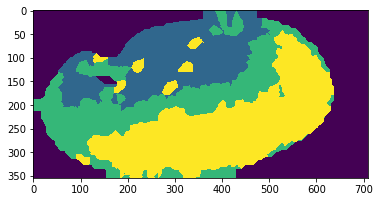

In [24]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(norm_data)

kmeans_prediction = kmeans.predict(norm_data)

show_prediction(cells, kmeans_prediction, "K-means clustering")

Train KMC on the locally averaged data

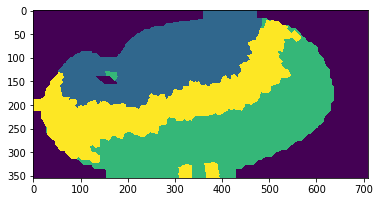

In [25]:
from sklearn.cluster import KMeans
import numpy as np

local_kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(norm_local_data)

local_kmeans_prediction = local_kmeans.predict(norm_local_data)

show_prediction(cells, local_kmeans_prediction, "K-means clustering")

# Time lapses
We do the whole procedure again to have a look at the course of gastrulation. Therefore we train GMM and KMC on a given time range: 

In [26]:
start_hour = 12
end_hour = 28

Convenience functions

In [27]:
def get_data(cc_dataset, start_hour, end_hour):
    """
    Collect data for a given time range of images. Every full hour, we take an image, segment it and extract features
    """
    d0 = []
    d1 = []

    for timepoint_in_h in range(start_hour, end_hour + 1):
        
        # load data
        input_image = cc_dataset.get_resampled_image(time_in_seconds=bs.hours_to_seconds(timepoint_in_h), linear_interpolation=False)

        # segment cells
        cells, spots = bs.segmentation(input_image, spot_detection_threshold=50)

        # measure distances
        avg_distance_map = cle.average_distance_of_n_closest_neighbors_map(cells, n = 6)

        # average locally
        local_avg_distance_map = cle.mean_of_touching_neighbors_map(avg_distance_map, cells)
        # measure standard deviation locally
        local_stddev_distance_map = cle.standard_deviation_of_touching_neighbors_map(local_avg_distance_map, cells, radius=2)

        d0.extend(cle.pull(cle.read_intensities_from_map(cells, local_avg_distance_map))[0])
        d1.extend(cle.pull(cle.read_intensities_from_map(cells, local_stddev_distance_map))[0])

    data =  np.asarray([
        d0,
        d1
    ]).T
    
    return data, cells, input_image

Read all measurements for the whole timelapse

In [28]:
data, _, _ = get_data(cc_dataset, start_hour, end_hour)
print(data.shape)

Segmentation took 0.34963393211364746 s
Segmentation took 0.3482096195220947 s
Segmentation took 0.3696169853210449 s
Segmentation took 0.3535881042480469 s
Segmentation took 0.35230135917663574 s
Segmentation took 0.38403797149658203 s
Segmentation took 0.3806130886077881 s
Segmentation took 0.3754136562347412 s
Segmentation took 0.35613393783569336 s
Segmentation took 0.3491673469543457 s
Segmentation took 0.39803457260131836 s
Segmentation took 0.358750581741333 s
Segmentation took 0.41814231872558594 s
Segmentation took 0.3906588554382324 s
Segmentation took 0.3437809944152832 s
Segmentation took 0.38832569122314453 s
Segmentation took 0.3596160411834717 s
(24420, 2)


Scale data

In [29]:
scaler = StandardScaler()
scaler.fit(data)
norm_data = scaler.transform(data)

Train GMM on the whole time lapse

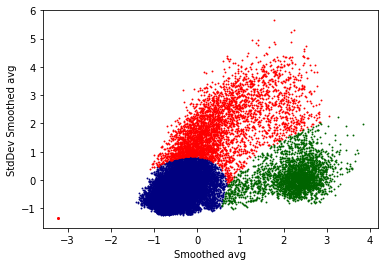

In [30]:
gmm = mixture.GaussianMixture(n_components=num_classes, covariance_type='full')
gmm.fit(norm_data)

gmm_prediction = gmm.predict(norm_data)

for i in range(num_classes):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(norm_data[gmm_prediction == i, 0], norm_data[gmm_prediction == i, 1], .8, color=color)

plt.xlabel("Smoothed avg")
plt.ylabel("StdDev Smoothed avg")
plt.show()

Train KMC on the whole time lapse

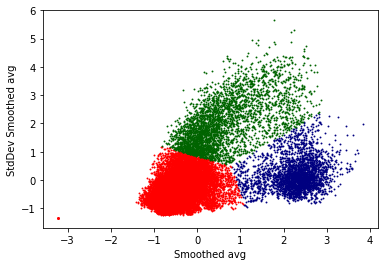

In [31]:
kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(norm_data)
kmeans_prediction = kmeans.predict(norm_data)

for i in range(num_classes):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(norm_data[kmeans_prediction == i, 0], norm_data[kmeans_prediction == i, 1], .8, color=color)

plt.xlabel("Smoothed avg")
plt.ylabel("StdDev Smoothed avg")
plt.show()

## GMM on a time lapse
Predict time point by timepoint

Segmentation took 0.354266881942749 s


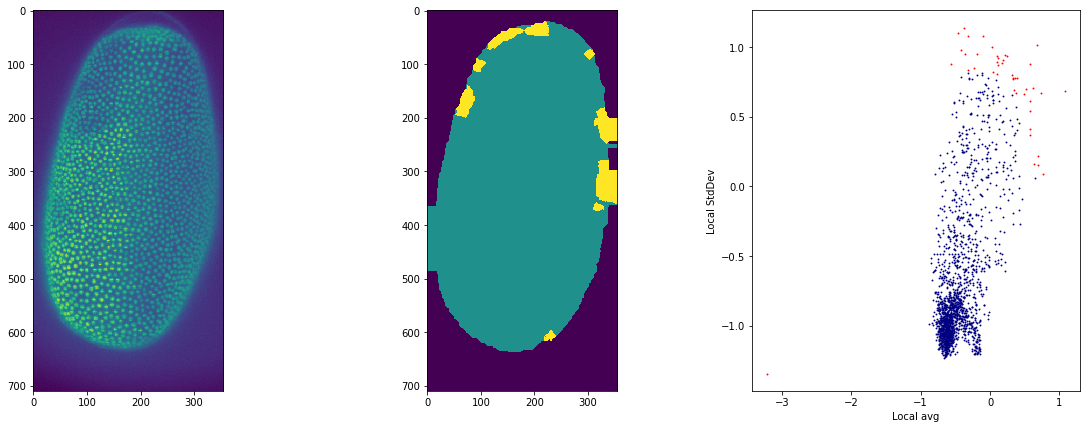

Segmentation took 0.37073183059692383 s


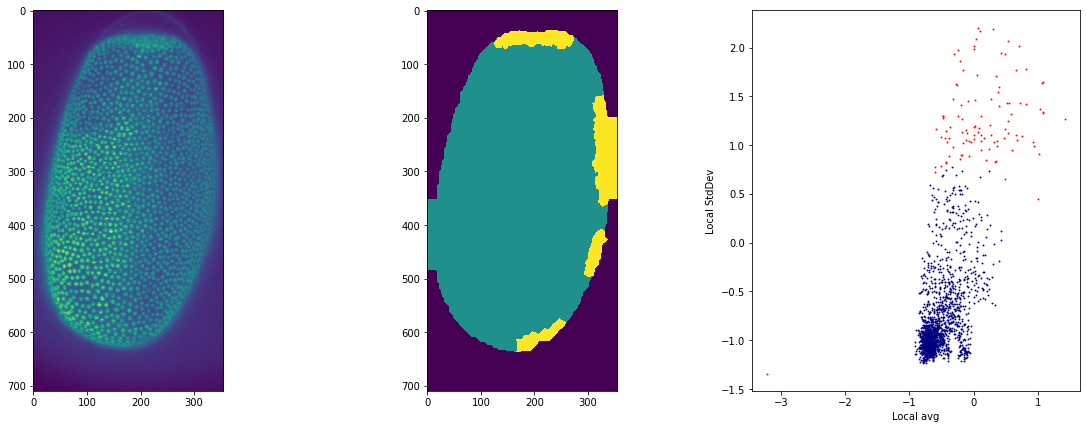

Segmentation took 0.3636434078216553 s


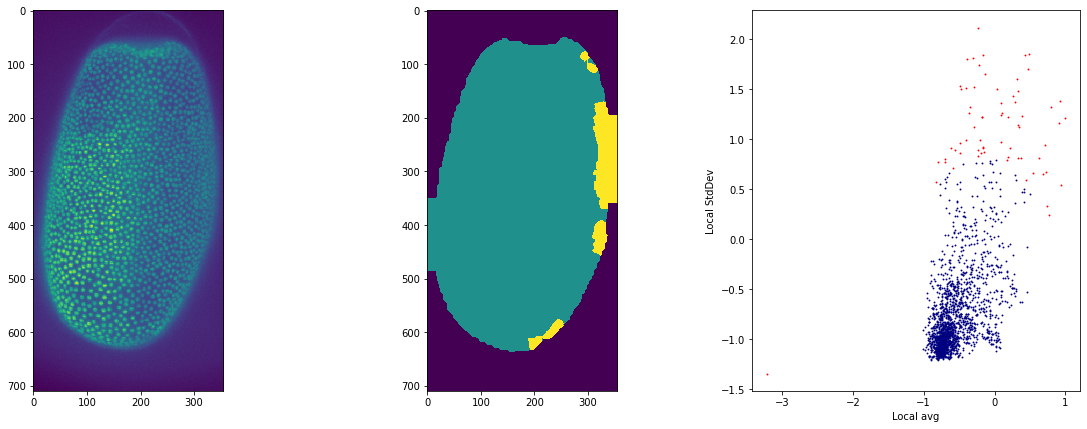

Segmentation took 0.3931407928466797 s


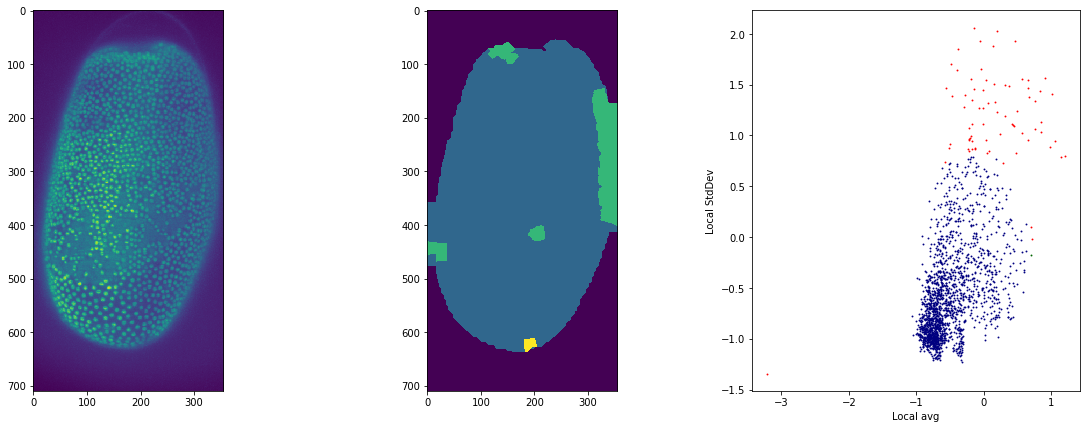

Segmentation took 0.3702867031097412 s


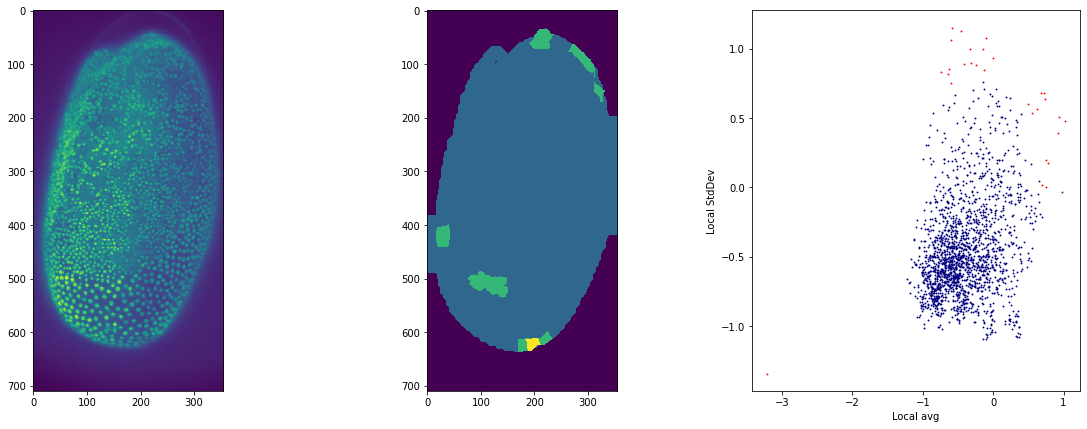

Segmentation took 0.34122681617736816 s


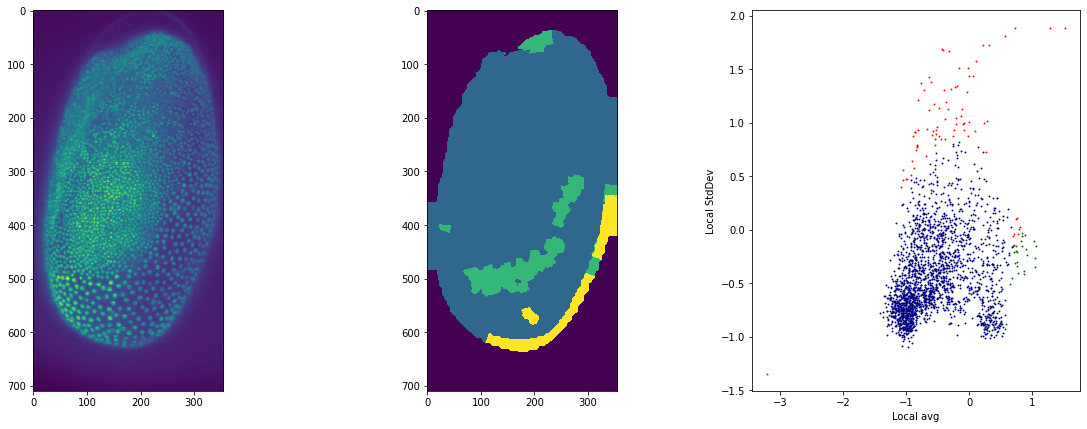

Segmentation took 0.3876776695251465 s


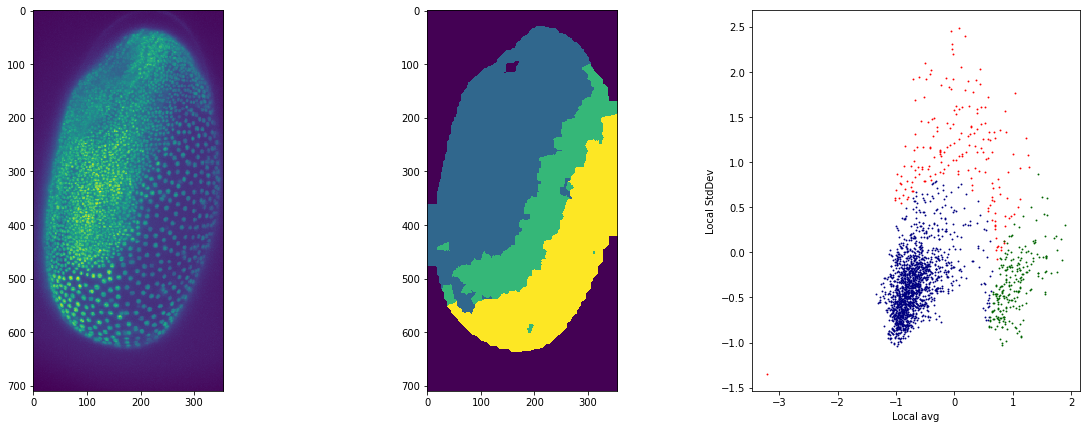

Segmentation took 0.3778653144836426 s


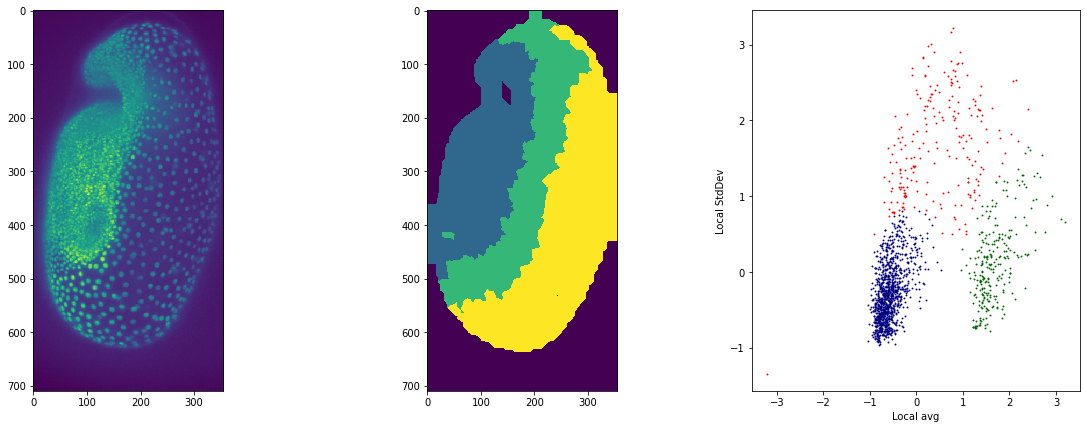

Segmentation took 0.35385942459106445 s


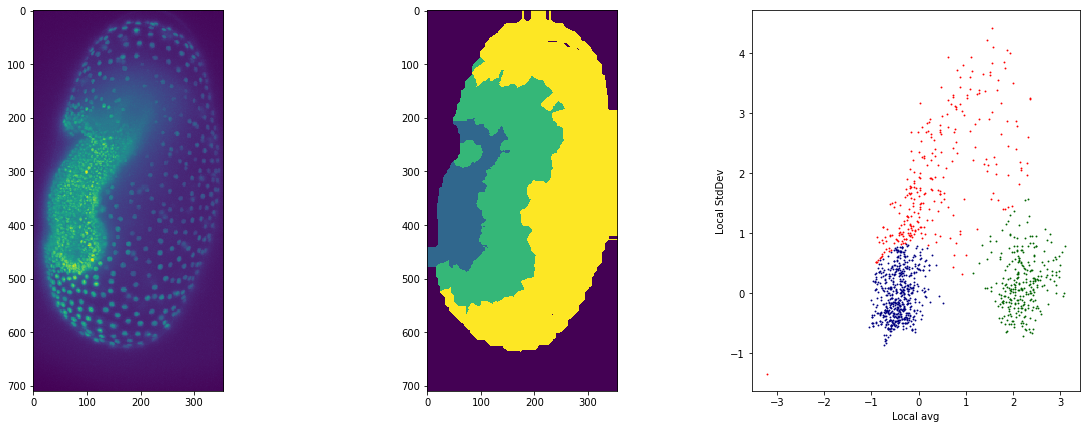

Segmentation took 0.3593721389770508 s


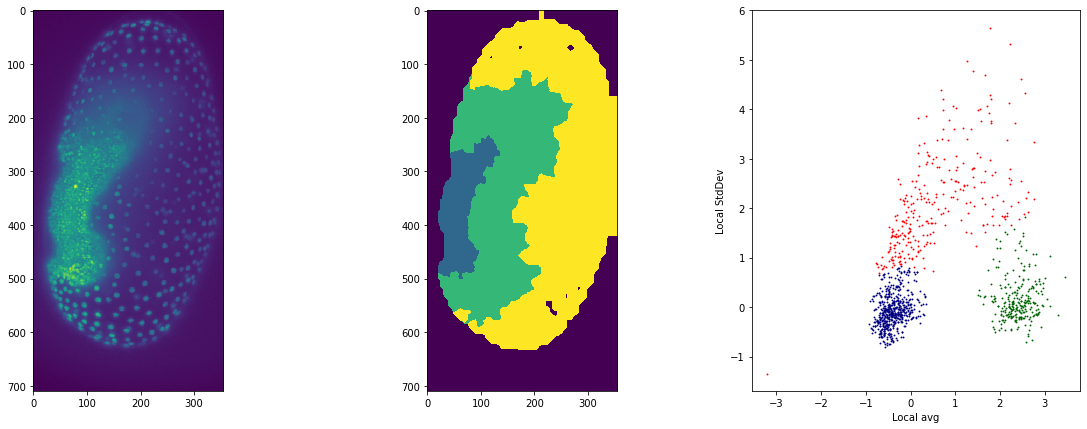

Segmentation took 0.3963627815246582 s


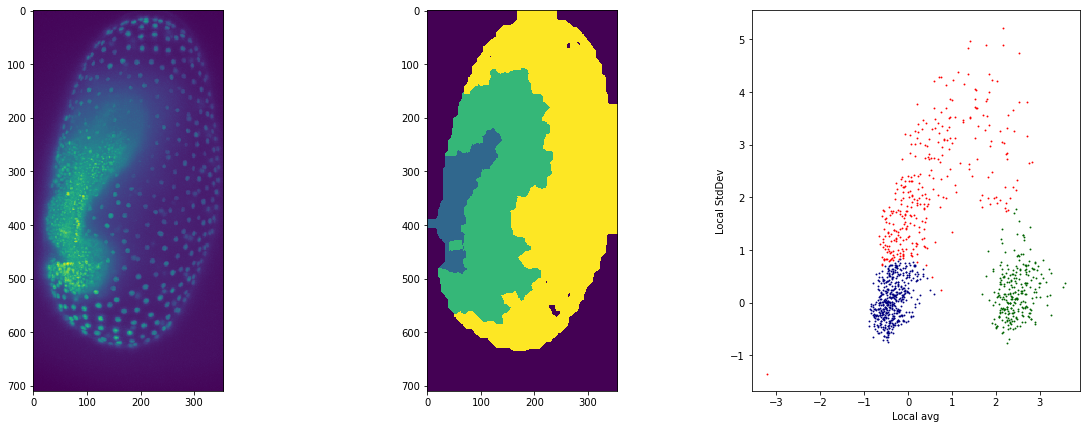

Segmentation took 0.3827190399169922 s


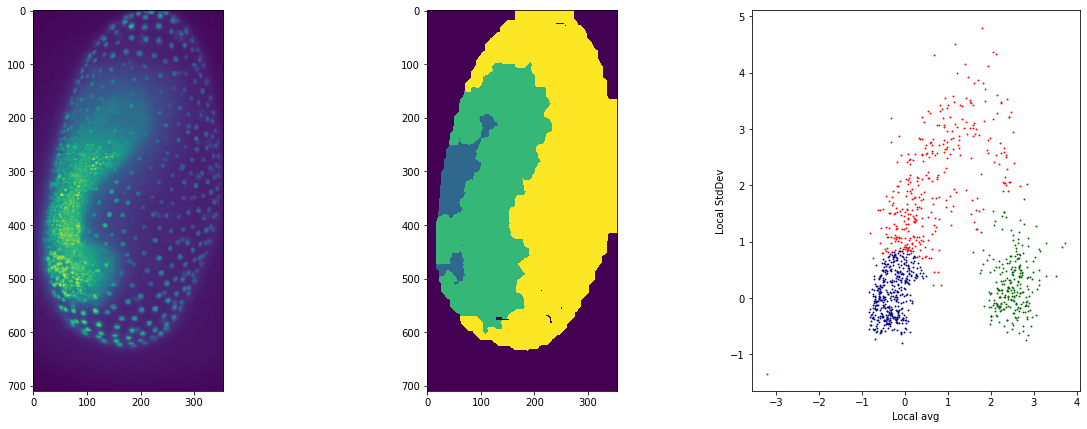

Segmentation took 0.35430312156677246 s


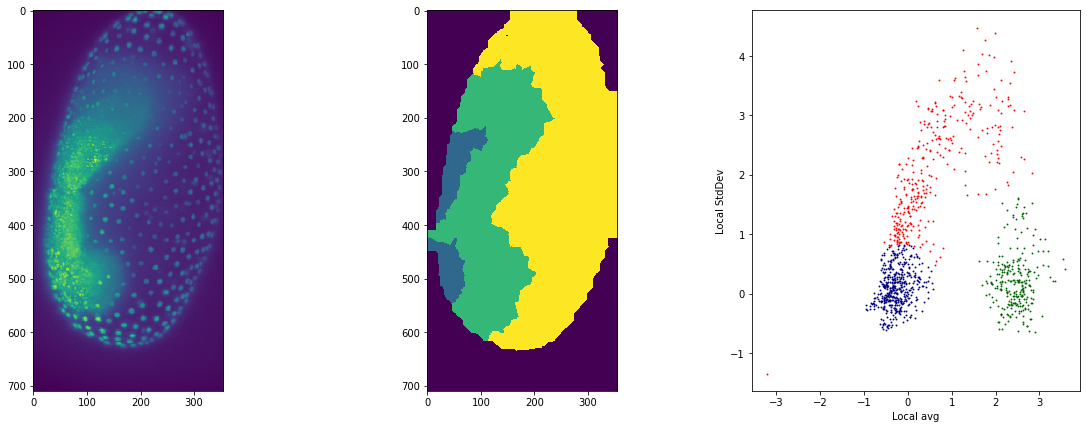

Segmentation took 0.33904337882995605 s


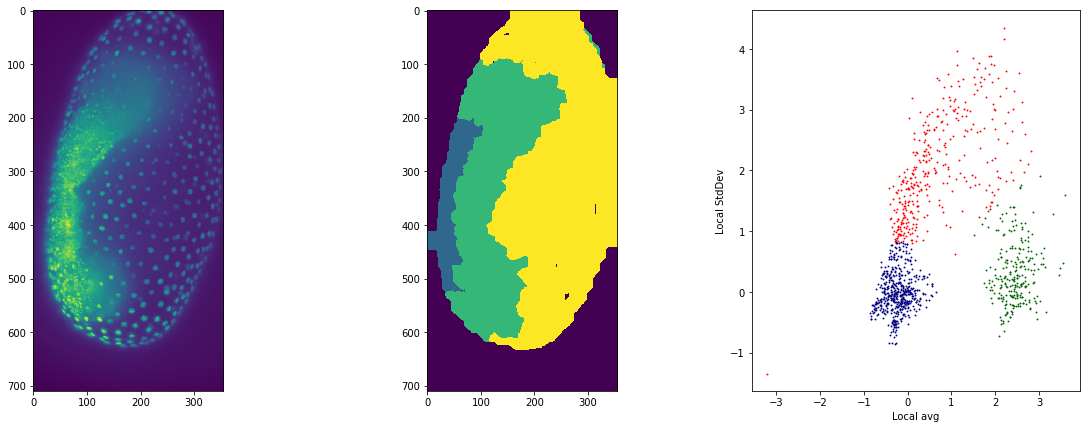

Segmentation took 0.35301733016967773 s


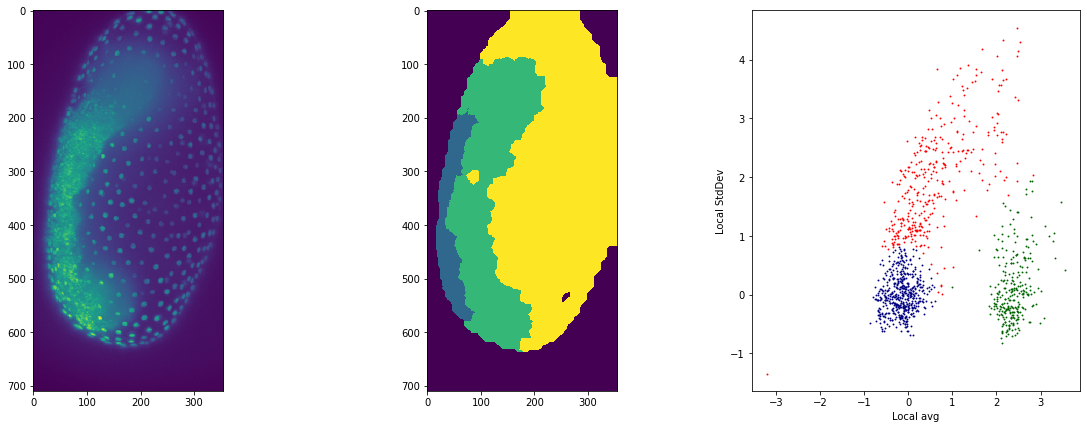

Segmentation took 0.3593780994415283 s


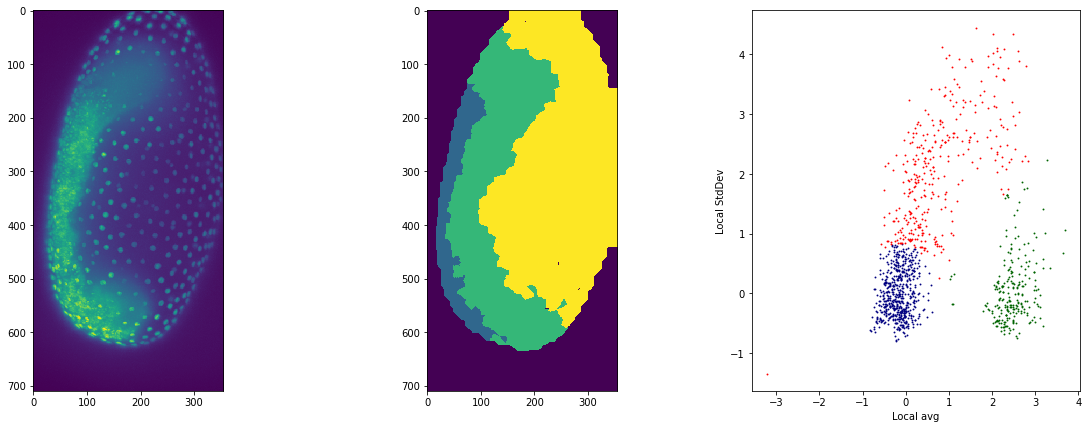

In [32]:
for timepoint_in_h in range(start_hour, end_hour):    
    # load, segment and get measurements
    data, cells, image = get_data(cc_dataset, timepoint_in_h, timepoint_in_h)
    
    # scale
    norm_data = scaler.transform(data)

    # predict
    gmm_prediction = gmm.predict(norm_data)

    classification_image = make_prediction(cells, gmm_prediction)

    # visualize
    fig, axs = plt.subplots(1, 3, figsize=(20, 7))

    cle.imshow(image, plot=axs[0])
    cle.imshow(classification_image, plot=axs[1])

    for i in range(num_classes):
        color = color_iter[i]
        axs[2].scatter(norm_data[gmm_prediction == i, 0], norm_data[gmm_prediction == i, 1], .8, color=color)
    axs[2].set_xlabel("Local avg")
    axs[2].set_ylabel("Local StdDev")    
    plt.show()

## KMC on a time lapse

Segmentation took 0.3674454689025879 s


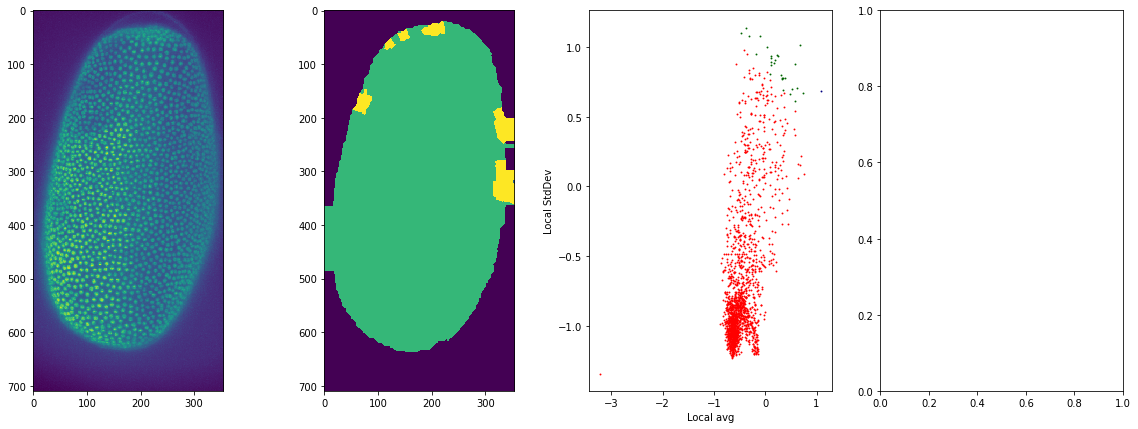

Segmentation took 0.37861013412475586 s


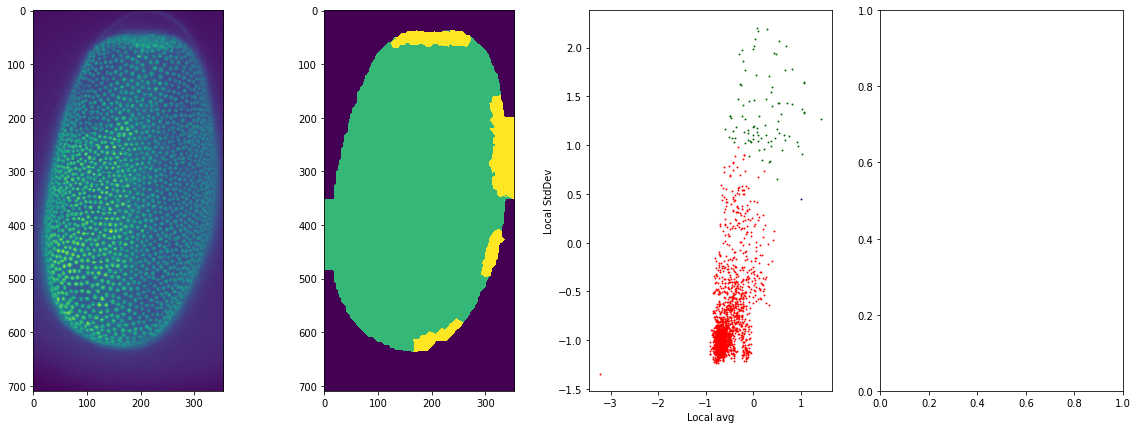

Segmentation took 0.35742783546447754 s


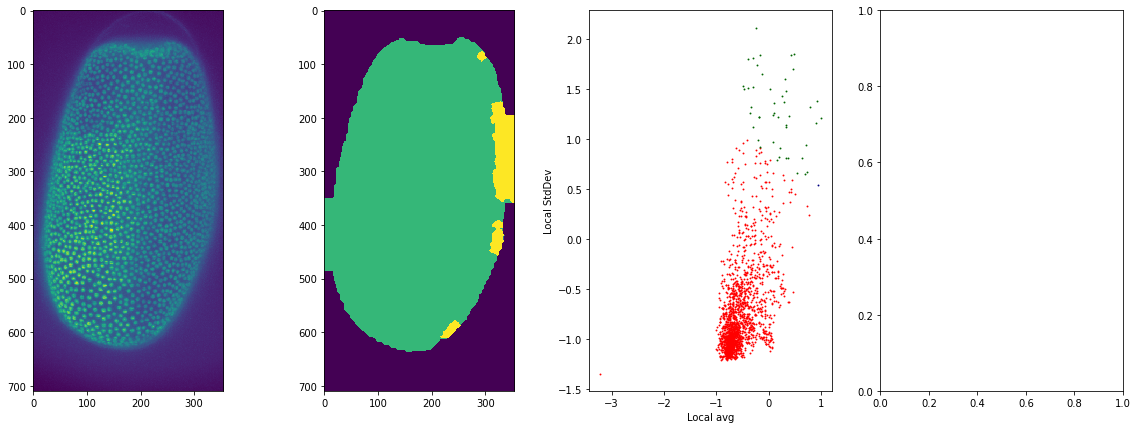

Segmentation took 0.3515183925628662 s


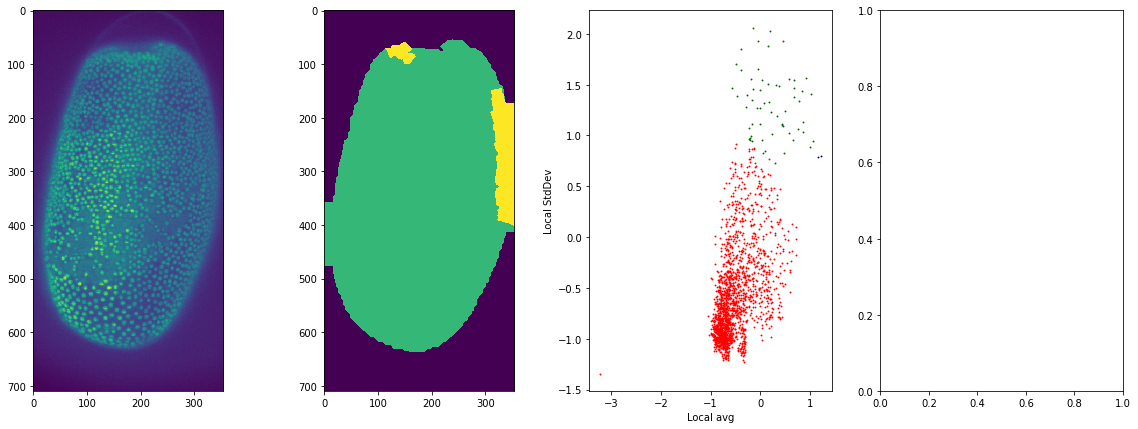

Segmentation took 0.350569486618042 s


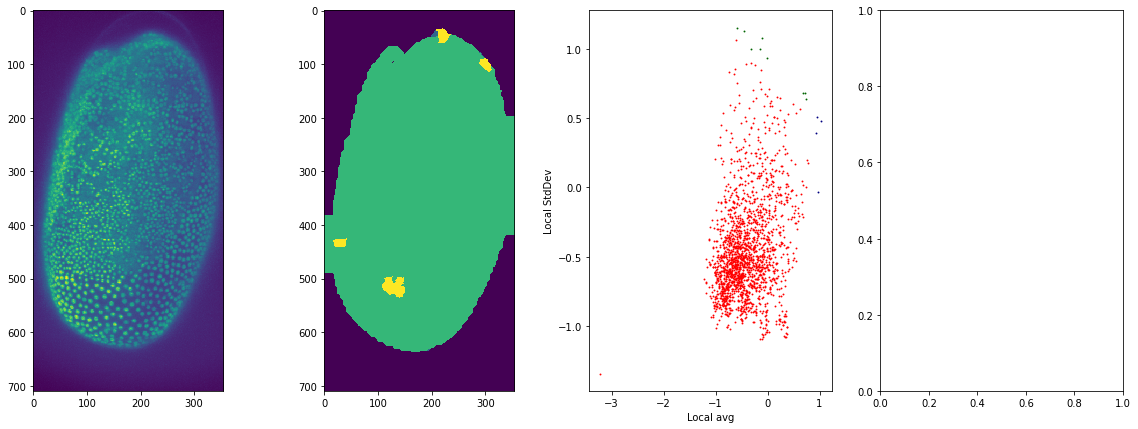

Segmentation took 0.360628604888916 s


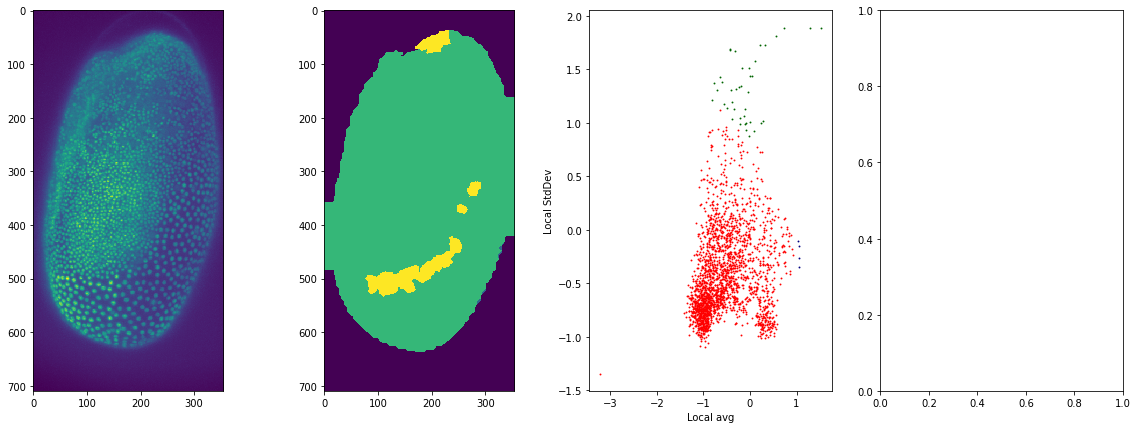

Segmentation took 0.3935253620147705 s


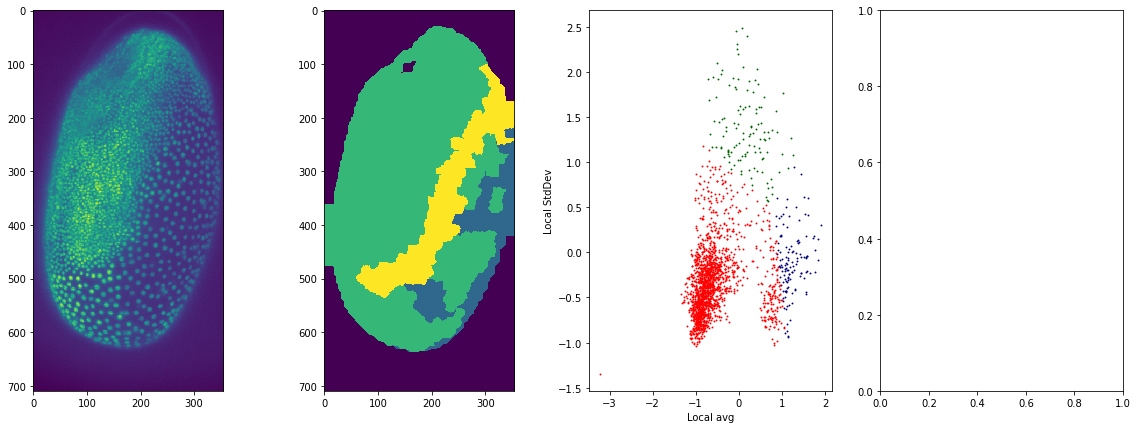

Segmentation took 0.3816812038421631 s


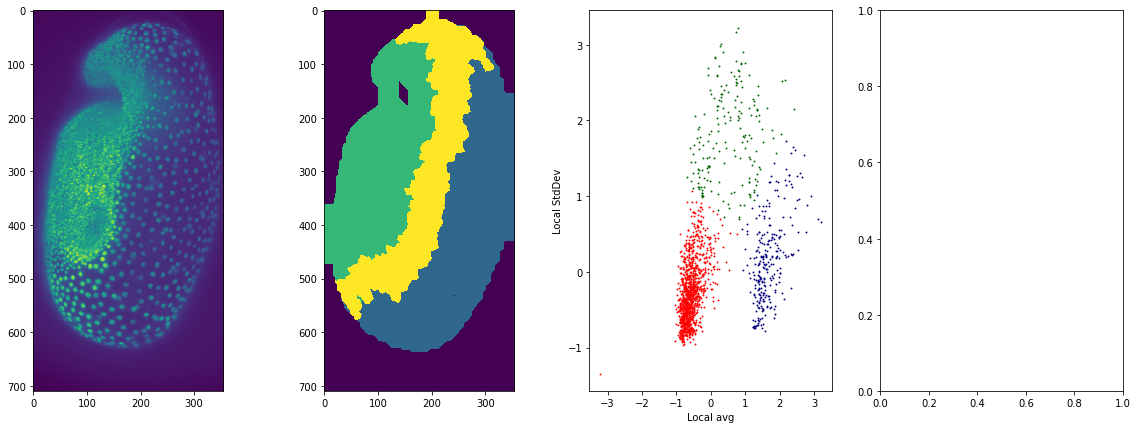

Segmentation took 0.37150049209594727 s


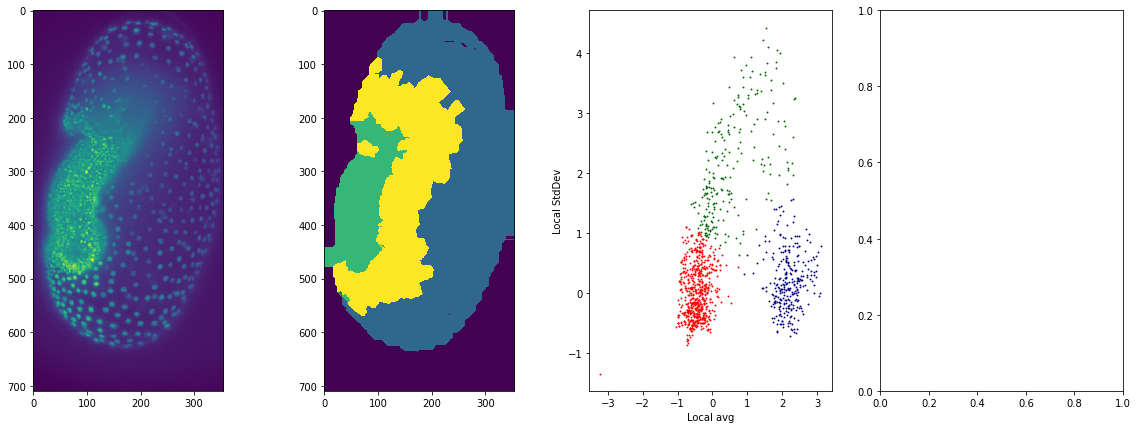

Segmentation took 0.4421195983886719 s


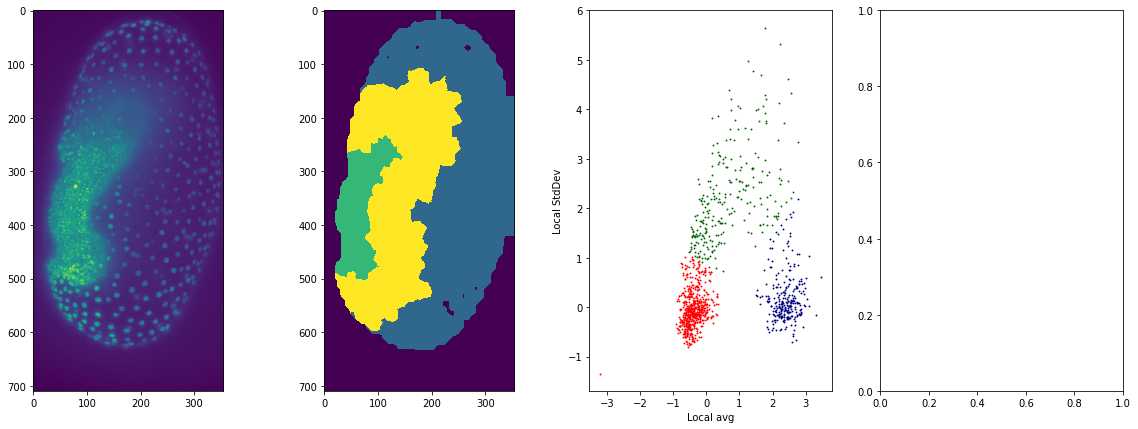

Segmentation took 0.4322178363800049 s


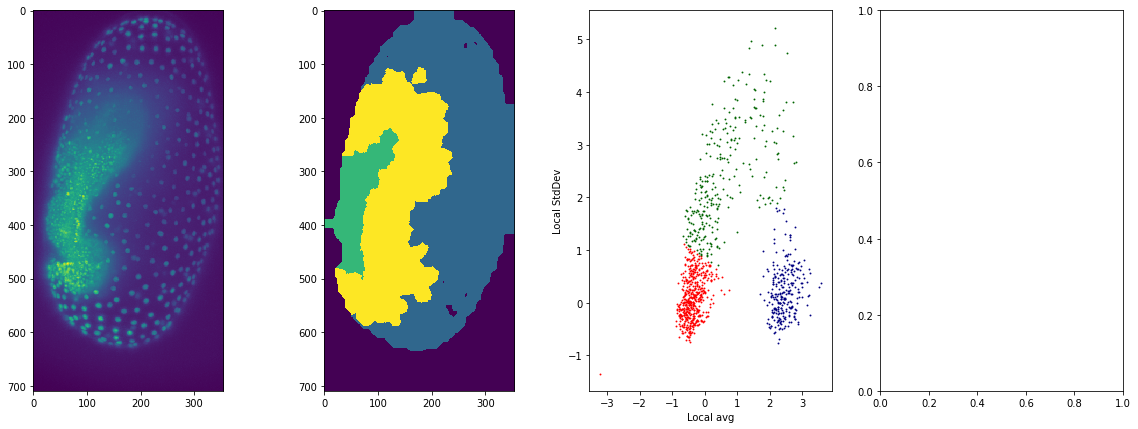

Segmentation took 0.42180609703063965 s


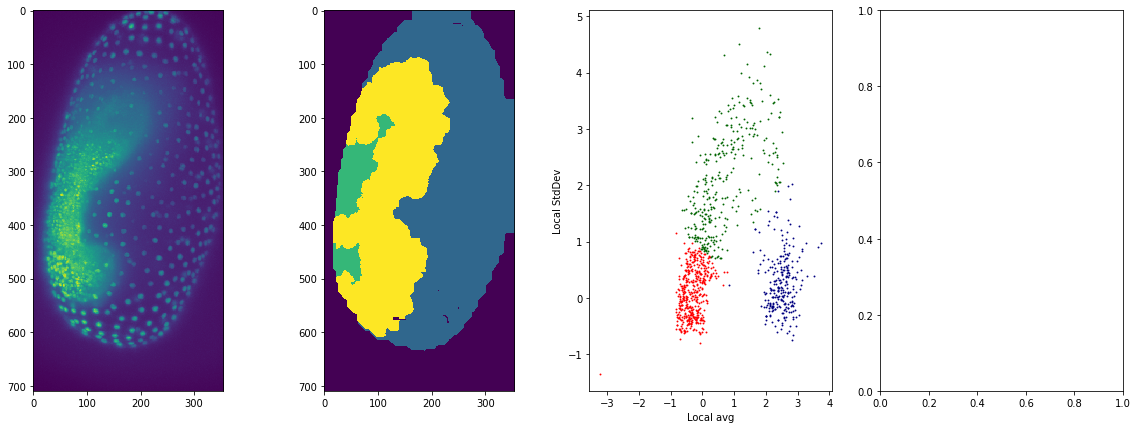

Segmentation took 0.42370152473449707 s


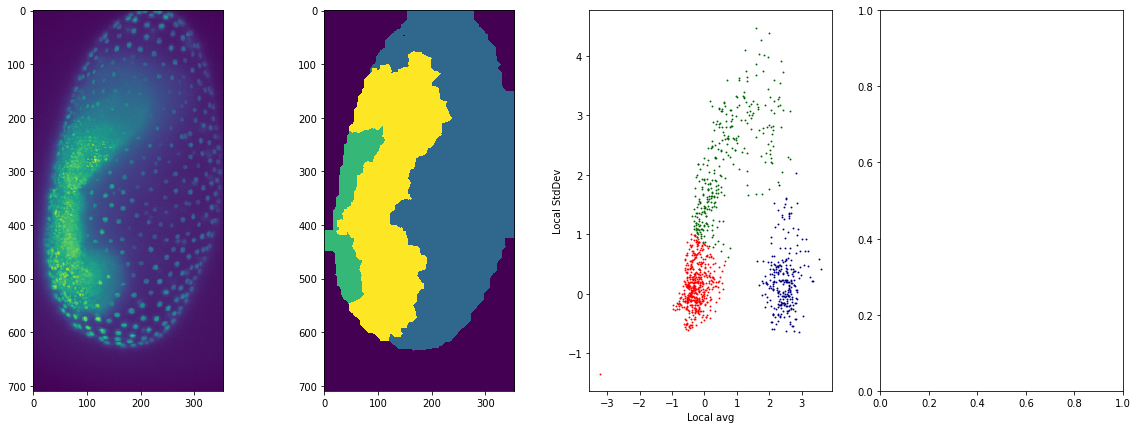

Segmentation took 0.43462705612182617 s


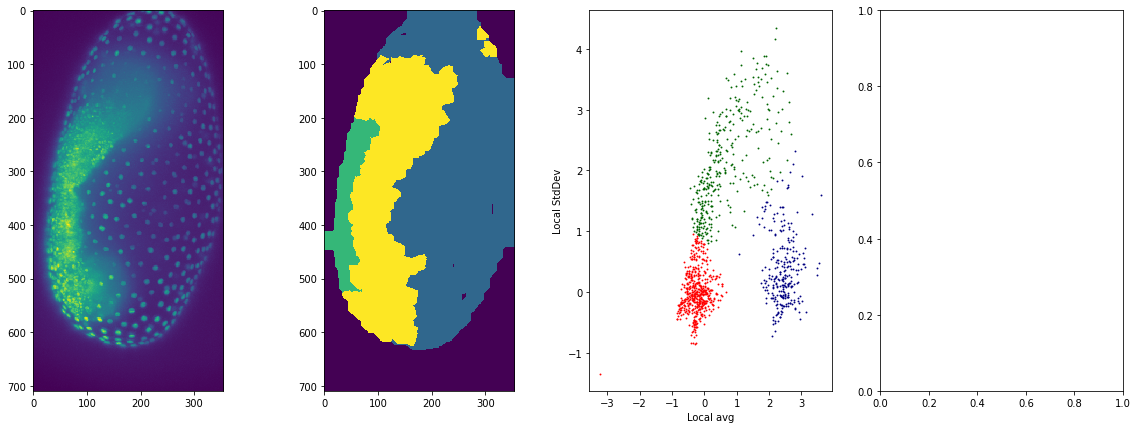

Segmentation took 0.4372744560241699 s


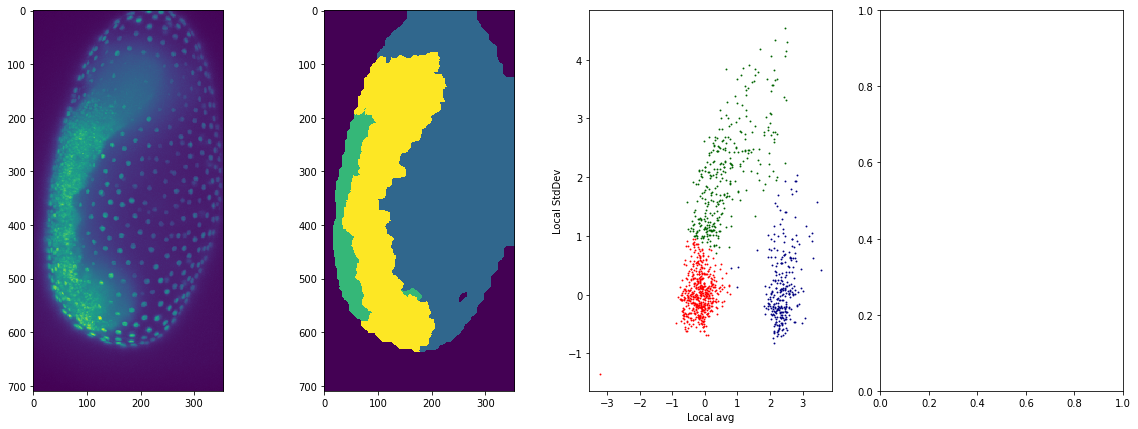

Segmentation took 0.4284396171569824 s


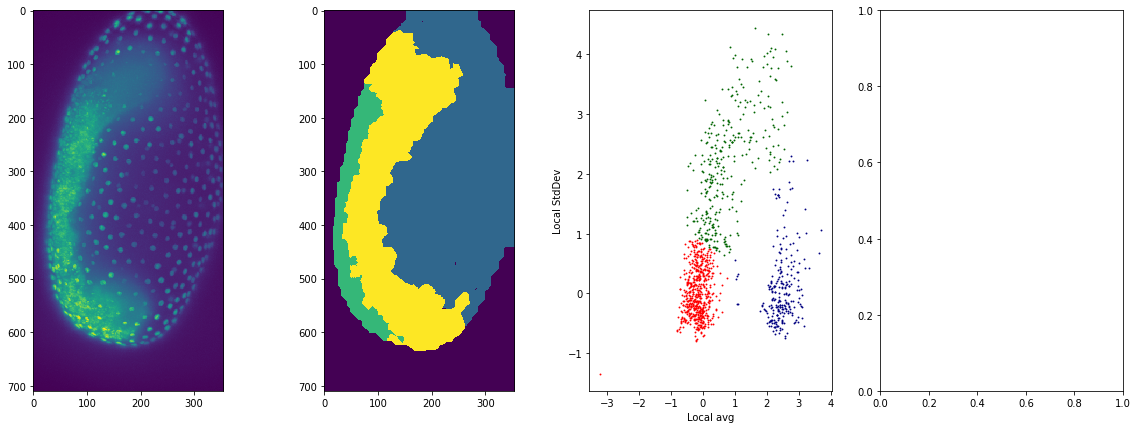

In [33]:
for timepoint_in_h in range(start_hour, end_hour):
    # load, segment and get measurements
    data, cells, image = get_data(cc_dataset, timepoint_in_h, timepoint_in_h)

    # scale
    norm_data = scaler.transform(data)

    # predict
    kmeans_prediction = kmeans.predict(norm_data)

    # visualize
    classification_image = make_prediction(cells, kmeans_prediction)

    fig, axs = plt.subplots(1, 4, figsize=(20, 7))

    cle.imshow(image, plot=axs[0])
    cle.imshow(classification_image, plot=axs[1])
        
    for i in range(num_classes):
        color = color_iter[i]
        axs[2].scatter(norm_data[kmeans_prediction == i, 0], norm_data[kmeans_prediction == i, 1], .8, color=color)
    axs[2].set_xlabel("Local avg")
    axs[2].set_ylabel("Local StdDev")    
    plt.show()